This notebook was modified from the original work of Pat Walters ([Some Thoughts on
Splitting Chemical
Datasets](https://practicalcheminformatics.blogspot.com/2024/11/some-thoughts-on-splitting-chemical.html))
to include the [BitBIRCH](https://www.biorxiv.org/content/10.1101/2024.08.10.607459v1)
clustering algorithm (from the work of the Miranda-Quintana Group), and a timing
comparison with the Taylor-Butina method.

Running this notebook **requires** installation of the `useful_rdkit_utils` by Pat
Walters package, together with other utilities (`tqdm`, `statsmodels`, and `lightgbm`).

In [2]:
!pip install useful_rdkit_utils tqdm statsmodels lightgbm

### Dataset Splitting

This notebook explores a few strategies for dataset splitting.  It also serves as a
demonstration of some of the splitting capabilities in useful_rdkit_utils. 

In [3]:
import itertools
import time

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator, AllChem
from rdkit.DataStructs import BulkTanimotoSimilarity, ExplicitBitVect
from rdkit.ML.Cluster import Butina
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from lightgbm import LGBMRegressor
import useful_rdkit_utils as uru
import bblean
import bblean.fingerprints

Wrapper class for LGBM, required to work with `useful_rdkit_utils`.

In [ ]:
class LGBMMorganCountWrapper:
    def __init__(self, y_col):
        self.lgbm = LGBMRegressor(verbose=-1)
        self.y_col = y_col
        self.fp_name = "fp"
        self.fg = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=1024)

    def fit(self, train):
        train["mol"] = train.SMILES.apply(Chem.MolFromSmiles)
        train[self.fp_name] = train.mol.apply(self.fg.GetCountFingerprintAsNumPy)
        self.lgbm.fit(np.stack(train.fp), train[self.y_col])

    def predict(self, test):
        test["mol"] = test.SMILES.apply(Chem.MolFromSmiles)
        test[self.fp_name] = test.mol.apply(self.fg.GetCountFingerprintAsNumPy)
        pred = self.lgbm.predict(np.stack(np.stack(test[self.fp_name])))
        return pred

    def validate(self, train, test):
        self.fit(train)
        pred = self.predict(test)
        return pred

#### Read the Input Data

Here are two demo datasets. The **biogen_logS** dataset contains the log of aqueous
solubility for a diverse datasets. The **Carbonic.smi** set is a more congeneric set of
carbonic anyhydrase inhibitors. The file **biogen_logS.csv** is from [a work on ML
algorithm validation by Cheng Fang et
al.](https://pubs.acs.org/doi/10.1021/acs.jcim.3c00160) The file **Carbonic.smi** is
from [the Deep Confidence work by Isidro Cortes-Ciriano et
al.](https://pubs.acs.org/doi/10.1021/acs.jcim.8b00542). 

In [4]:
df = pd.read_csv("biogen_logS.csv")
#df = pd.read_csv("Carbonic.smi",sep=" ",names=["SMILES","Name","pIC50"])

#### Cluster the Data

In the next four cells we use functions from [useful_rdkit_utils](xxx) to define groups
that will be used with **GroupKFoldShuffle** to generate training and test sets for
cross validation. Molecules in the same cluster will be placed in either the training
set or the test set, but not both.  The first method **get_random_split** simply puts
every molecule into its own cluster, and can be used to generate a random split. 

In [5]:
df['random_cluster'] = uru.get_random_clusters(df.SMILES)

The **get_bemis_murcko_clusters** method identifies the [Bemis-Murcko
frameworks](https://pubs.acs.org/doi/10.1021/jm9602928), as defined by the
[RDKit](https://www.rdkit.org/docs/source/rdkit.Chem.Scaffolds.MurckoScaffold.html), in
each molecule and assigns each unique scaffold to a cluster. 

In [6]:
df['scaffold_cluster'] = uru.get_bemis_murcko_clusters(df.SMILES)

The **get_butina_clusters** method starts by using the [Butina clustering
method](https://pubs.acs.org/doi/pdf/10.1021/ci9803381) in the
[RDKit](https://rdkit.org/docs/source/rdkit.ML.Cluster.Butina.html) to cluster
molecules.  The default distance cutoff is 0.65, which corresponds to Tanimoto
similairity of 0.35. 

In [7]:
df['butina_cluster'] = uru.get_butina_clusters(df.SMILES)

The **get_umap_clusters** method follows a [paper](https://arxiv.org/abs/2406.00873) by
Pedro Ballester's group.  In the paper, the Morgan fingerprints for the molecules are
projected into a 2-dimensional space using the umap algorithm.  This 2-dimensional space
is then clustered into 7 clusters using the AgglomerativeClustering method in
scikit-learn. 

In [8]:
df['umap_cluster'] = uru.get_umap_clusters(df.SMILES, n_clusters=7)

After the operations above, the dataframe has four new columns corresponding to the
clusters obtained using the methods in **useful_rdkit_utils**. We now are adding a
function, **get_bitbirch_clusters**, to compute **BitBIRCH** clusters from SMILES given
in the dataframe.

In [11]:
def get_bitbirch_clusters(smiles_list):
    mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]
    fps = np.array([Chem.RDKFingerprint(mol) for mol in mols])
    bitbirch = bblean.BitBirch(branching_factor=50, threshold=0.65)  
    bitbirch.fit(fps)
    cluster_list = bitbirch.get_cluster_mol_ids()  
    
#     # Map each mol ID to its cluster ID
    n_molecules = len(fps)
    cluster_labels = [0] * n_molecules
    for cluster_id, indices in enumerate(cluster_list):
        for idx in indices:
            cluster_labels[idx] = cluster_id
    return cluster_labels

The following cell will add a column to the dataframe with a the corresponding
**BitBIRCH** cluster IDs, as well as save the binary fingerprints. 

In [12]:
df['bitbirch_cluster'] = get_bitbirch_clusters(df.SMILES)

In [13]:
df

Internal ID    Vendor ID  \
0           Mol1    317714313   
1           Mol2    324056965   
2           Mol4    194963090   
3           Mol6    316230505   
4           Mol9  EN300-97039   
...          ...          ...   
2168     Mol3493     36272797   
2169     Mol3494     48313392   
2170     Mol3495     37024444   
2171     Mol3496       419556   
2172     Mol3497     42587186   

                                                 SMILES CollectionName  \
0     CNc1cc(Nc2cccn(-c3ccccn3)c2=O)nn2c(C(=O)N[C@@H...     emolecules   
1     CCOc1cc2nn(CCC(C)(C)O)cc2cc1NC(=O)c1cccc(C(F)F)n1     emolecules   
2     CC(C)(Oc1ccc(-c2cnc(N)c(-c3ccc(Cl)cc3)c2)cc1)C...     emolecules   
3     CC#CC(=O)N[C@H]1CCCN(c2c(F)cc(C(N)=O)c3[nH]c(C...     emolecules   
4     C=CC(=O)N1CCC[C@@H](n2nc(-c3ccc(Oc4ccccc4)cc3)...  enamineBB_pmc   
...                                                 ...            ...   
2168                   Cc1cc(C)cc(C(=O)NCCCNc2ncccn2)c1     emolecules   
2169                         CCc1noc(COc2c(C)ccnc2Cl)n1     emolecules   
2170          CC(C)(C)Cc1nnc(-c2cnc3onc(C4CCCC4)c3c2)o1     emolecules   
2171      Cc1nonc1C(=O)NCCc1c[nH]c2cccc(C3(O)CCOCC3)c12     emolecules   
2172                        CN1CC(=O)N(CCOc2ccccc2)C1=O     emolecules   

          logS  random_cluster  scaffold_cluster  butina_cluster  \
0    -5.548020               0                 0            1067   
1    -5.071409               1                 1            1066   
2    -3.925969               2                 2            1065   
3    -4.535280               3                 3            1064   
4    -4.709963               4                 4              55   
...        ...             ...               ...             ...   
2168 -3.733424            2168              1880             248   
2169 -4.037319            2169              1881             189   
2170 -4.912777            2170              1882             359   
2171 -3.781930            2171              1883             358   
2172 -4.007018            2172              1884             183   

      umap_cluster  bitbirch_cluster  
0                5              1747  
1                2              1802  
2                2              1881  
3                1              1803  
4                1                 5  
...            ...               ...  
2168             2              1936  
2169             0               721  
2170             0               365  
2171             5                51  
2172             6               727  

[2173 rows x 10 columns]

#### Comparing Dataset Sizes

Perform 5x5 cross-validation and examine the dataset sizes produced by the five
splitting strategies. 

In [14]:
size_df = pd.read_csv("biogen_logS.csv")
size_df['mol'] = size_df.SMILES.apply(Chem.MolFromSmiles)
fpgen = rdFingerprintGenerator.GetMorganGenerator()
size_df['fp'] = size_df.mol.apply(fpgen.GetCountFingerprintAsNumPy)
size_df['binary_fps'] = size_df.mol.apply(Chem.RDKFingerprint)

SPLIT_LIST = ["random_cluster","butina_cluster","umap_cluster","scaffold_cluster", "bitbirch_cluster"]
split_fn_dict = {"random_cluster"   : uru.get_random_clusters,
              "butina_cluster"   : uru.get_butina_clusters,
              "umap_cluster"     : uru.get_umap_clusters,
              "scaffold_cluster" : uru.get_bemis_murcko_clusters, 
              "bitbirch_cluster" : get_bitbirch_clusters}

result_list =  []
for split in SPLIT_LIST:
    for i in tqdm(range(0,5),desc=split):
        cluster_list = split_fn_dict[split](size_df.SMILES)
        group_kfold_shuffle = uru.GroupKFoldShuffle(n_splits=5, shuffle=True)
        if split == 'bitbirch_cluster':
            for train, test in group_kfold_shuffle.split(np.stack(size_df.binary_fps),size_df.logS,cluster_list):
                result_list.append([split,len(test)])
        else:
            for train, test in group_kfold_shuffle.split(np.stack(size_df.fp),size_df.logS,cluster_list):
                result_list.append([split,len(test)])
result_df = pd.DataFrame(result_list,columns=["split","num_test"])

random_cluster:   0%|          | 0/5 [00:00<?, ?it/s]

butina_cluster:   0%|          | 0/5 [00:00<?, ?it/s]

umap_cluster:   0%|          | 0/5 [00:00<?, ?it/s]

scaffold_cluster:   0%|          | 0/5 [00:00<?, ?it/s]

bitbirch_cluster:   0%|          | 0/5 [00:00<?, ?it/s]

As expected, the test set sizes are the same when **random_cluster** is used.  With
**butina_cluster**, **scaffold_cluster**, and **bitbirch_cluster** we see a bit more
variability in test set sizes.  When we use **umap_cluster** there a large variability
in the test size. 

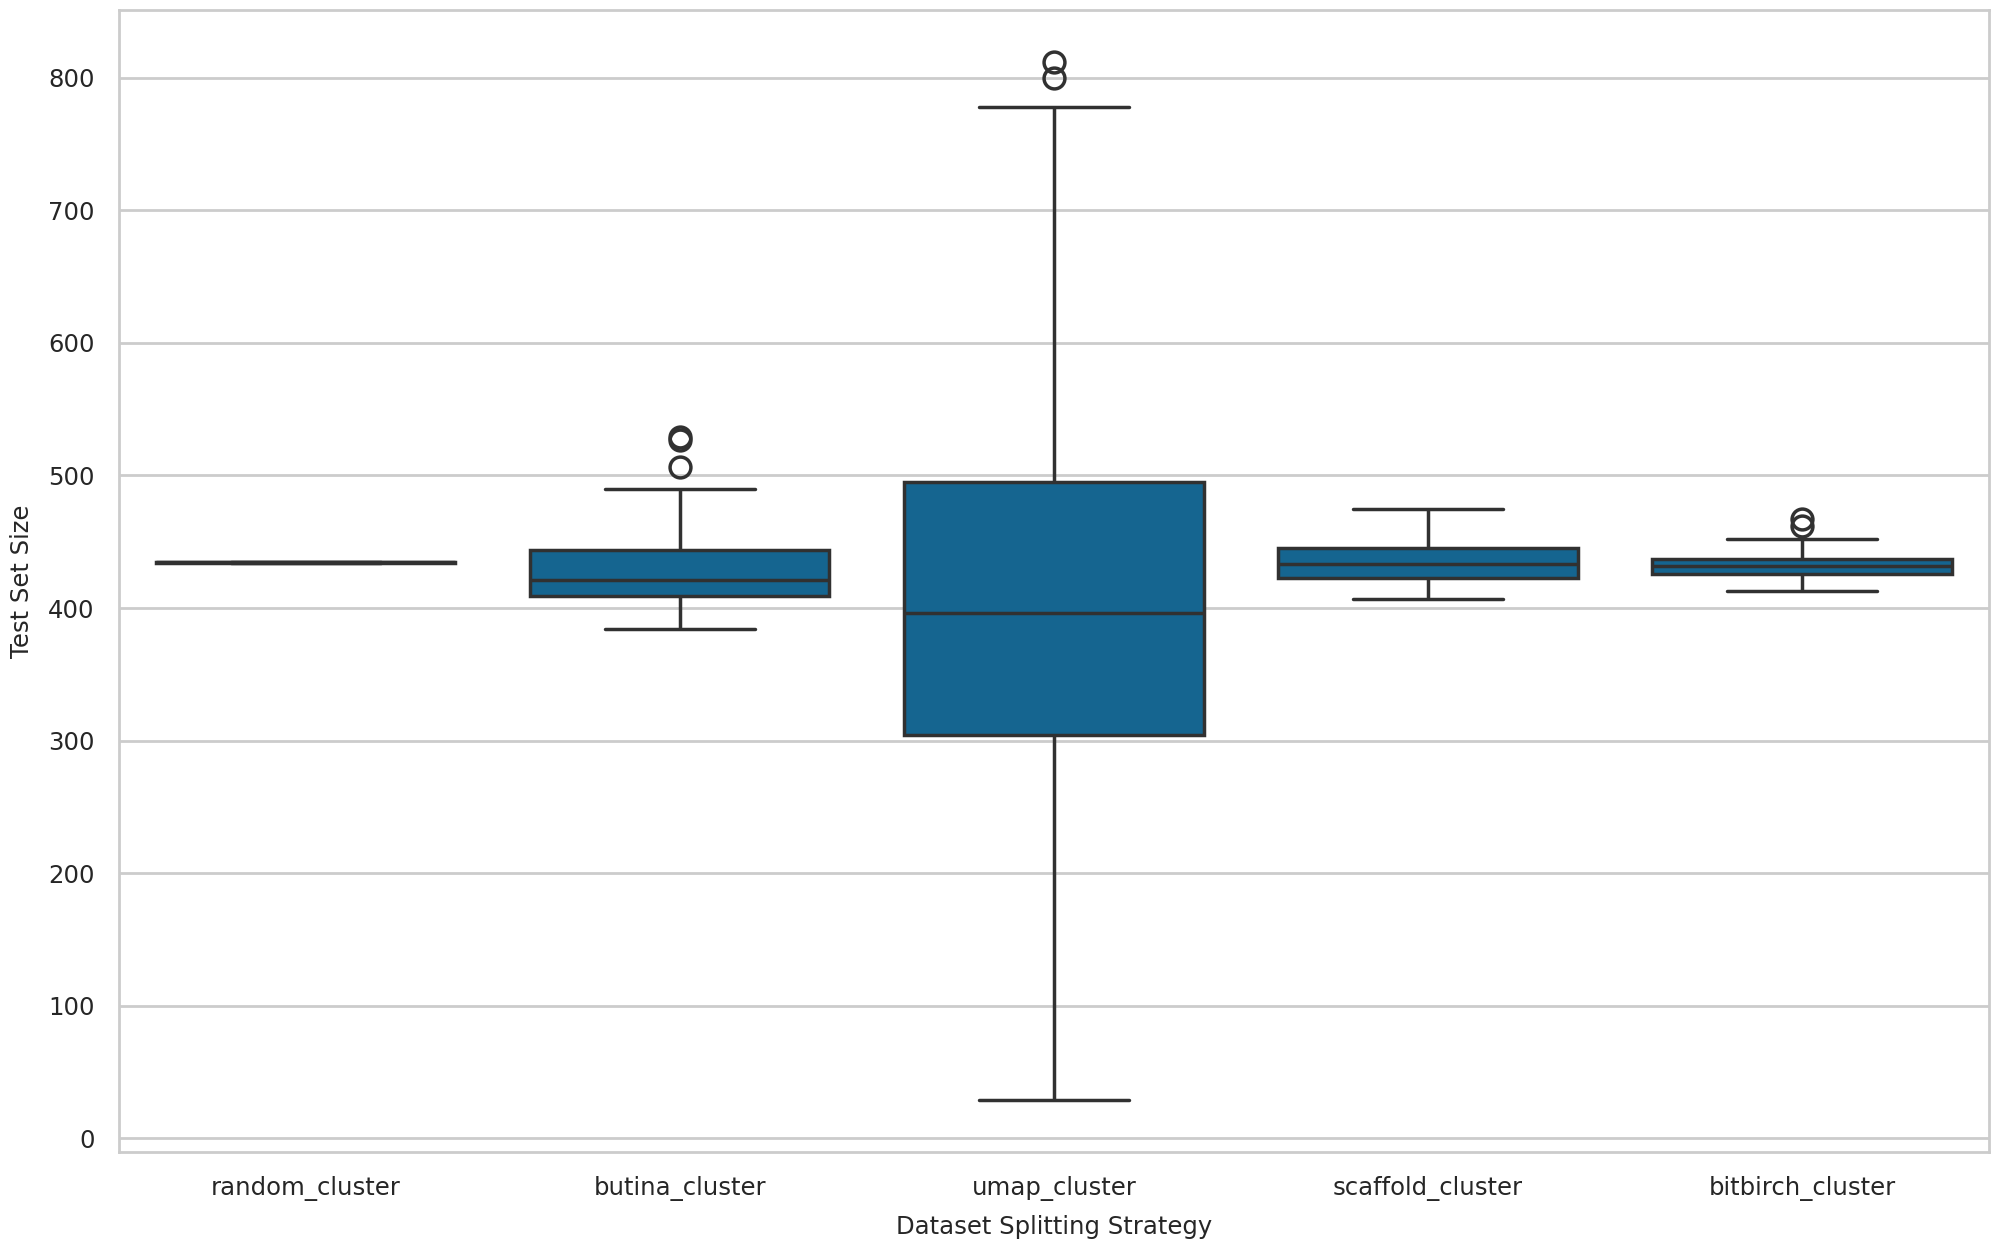

In [16]:
sns.set_style('whitegrid')
plt.figure(figsize=(8,5))
ax = sns.boxplot(x="split",y="num_test",data=result_df)
ax.set_xlabel("Dataset Splitting Strategy")
ax.set_ylabel("Test Set Size")
plt.show()

The variability in test set size with **umap_cluster** can be attributed to the
variation in cluster sizes.  Some of this may be due to the fact that we're only using 7
clusters.  Let's examine the impact of the number of clusters from
AgglomerativeClustering on the size of the test sets. 

In [17]:
urc_result_list = []
for num_clus in tqdm(range(5,76,5)):
    for i in range(0,5):
        cluster_list = uru.get_umap_clusters(size_df.SMILES,n_clusters=num_clus)
        group_kfold_shuffle = uru.GroupKFoldShuffle(n_splits=5, shuffle=True)
        for train, test in group_kfold_shuffle.split(np.stack(size_df.fp),size_df.logS,cluster_list):
            urc_result_list.append([num_clus,len(test)])
urc_result_df = pd.DataFrame(urc_result_list,columns=["num_clus","num_test"])   

  0%|          | 0/15 [00:00<?, ?it/s]

Looking at the plot below, the test set size seems to stabilize when we reach about 35 clusters. 

Text(0, 0.5, 'Number of Test Set Molecules')

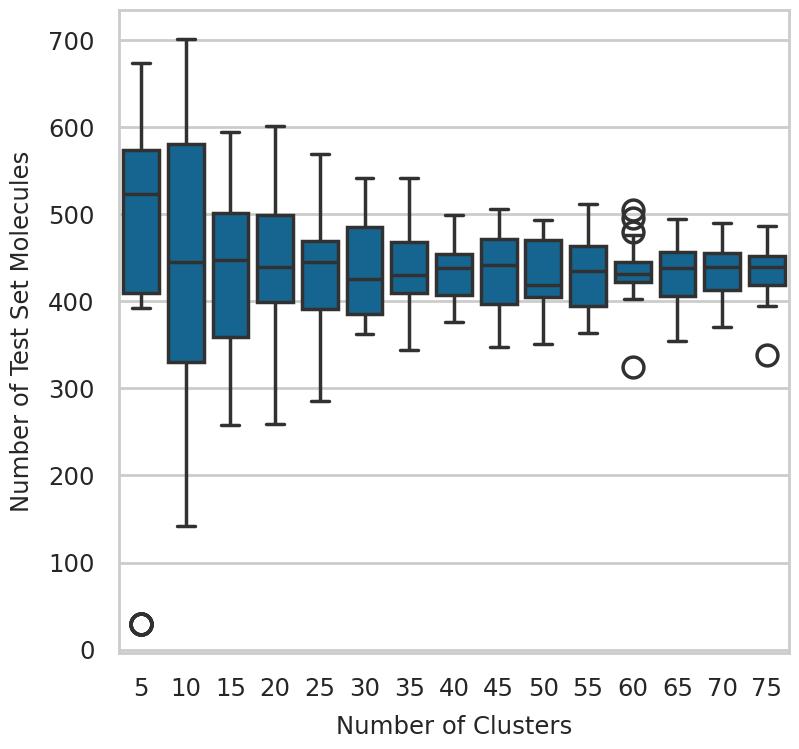

In [18]:
sns.set_style('whitegrid')
ax = sns.boxplot(x="num_clus",y="num_test",data=urc_result_df)
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("Number of Test Set Molecules")

#### Make t-SNE Plots to Compare the Data Splits 

We would like to generate a plot to visualize the training and test set distributions
for our dataset using the different splitting methods.  To do this, we'll project the
fingerprints into two dimensions using truncate stochastic neighbor embedding (tSNE).  

In [19]:
def get_tsne_coords(smiles_list):
    fp_gen = rdFingerprintGenerator.GetMorganGenerator()
    mol_list = [Chem.MolFromSmiles(x) for x in smiles_list]
    fp_list = [fp_gen.GetFingerprintAsNumPy(x) for x in mol_list]   #Using binary fingerprints in this test
    pca = PCA(n_components=50)
    pcs = pca.fit_transform(fp_list)
    tsne = TSNE(n_components=2, init='pca', learning_rate='auto')
    res = tsne.fit_transform(pcs)
    tsne_x = res[:,0]
    tsne_y = res[:,1]
    return tsne_x, tsne_y

Use **GroupKFoldShuffle** to split the dataset using each of methods we defined above.
Since this is simply a visual illustration, we'll only do one round of cross validation. 

In [20]:
split_dict = {}
for split in SPLIT_LIST:
    kf = uru.GroupKFoldShuffle(n_splits=5, shuffle=True)
    for train_idx, test_idx in kf.split(df,groups=df[split]):
        split_dict[split] = [train_idx, test_idx]
        break

Any cross validation method that splits a dataset based on clusters, won't produce the
same test set size every time.  Let's look at the training and test set sizes. 

In [21]:
for k,v in split_dict.items():
    print(k,len(v[0]),len(v[1]))

random_cluster 1738 435

butina_cluster 1750 423

umap_cluster 1631 542

scaffold_cluster 1732 441

bitbirch_cluster 1733 440

Get tSNE 2D coordinates for the molecules and add them to the dataframe. 

In [22]:
tsne_x, tsne_y = get_tsne_coords(df.SMILES)

df['tsne_x'] = tsne_x
df['tsne_y'] = tsne_y

Create a new dataframe with the tSNE coordiantes. 

In [23]:
tmp_df = df[['tsne_x','tsne_y']].copy()
tmp_df.reset_index(inplace=True)

Add training and test set labels to **tmp_df** using the four splitting methods defined above. 

In [25]:
for split in SPLIT_LIST:
    tmp_df[split] = "train"
    _, test_idx = split_dict[split]
    for t in test_idx:
        tmp_df.loc[t, split] = "test"

Plot the chemical space of the dataset and show the training set in light blue and the
test set in red. To be honest, I don't see a large difference between the plots. The
only obvious difference is with **umap_cluster** where the test set is much more
localized. 

In [26]:
tmp_df

index     tsne_x     tsne_y random_cluster butina_cluster umap_cluster  \
0         0  10.417018 -12.192085          train           test        train   
1         1 -43.058537 -23.109076          train           test        train   
2         2 -13.704280  44.354630          train          train        train   
3         3  29.623981 -15.113812          train          train        train   
4         4  43.718029   0.091656          train          train        train   
...     ...        ...        ...            ...            ...          ...   
2168   2168 -28.279984 -19.862623          train          train        train   
2169   2169  -4.321488  37.268566          train          train         test   
2170   2170  -5.665515  40.423023           test          train         test   
2171   2171 -38.635723 -34.326500          train          train        train   
2172   2172  12.734663  -2.612435          train          train        train   

     scaffold_cluster bitbirch_cluster  
0               train             test  
1               train             test  
2                test            train  
3               train            train  
4                test            train  
...               ...              ...  
2168            train             test  
2169            train             test  
2170            train             test  
2171            train            train  
2172            train            train  

[2173 rows x 8 columns]

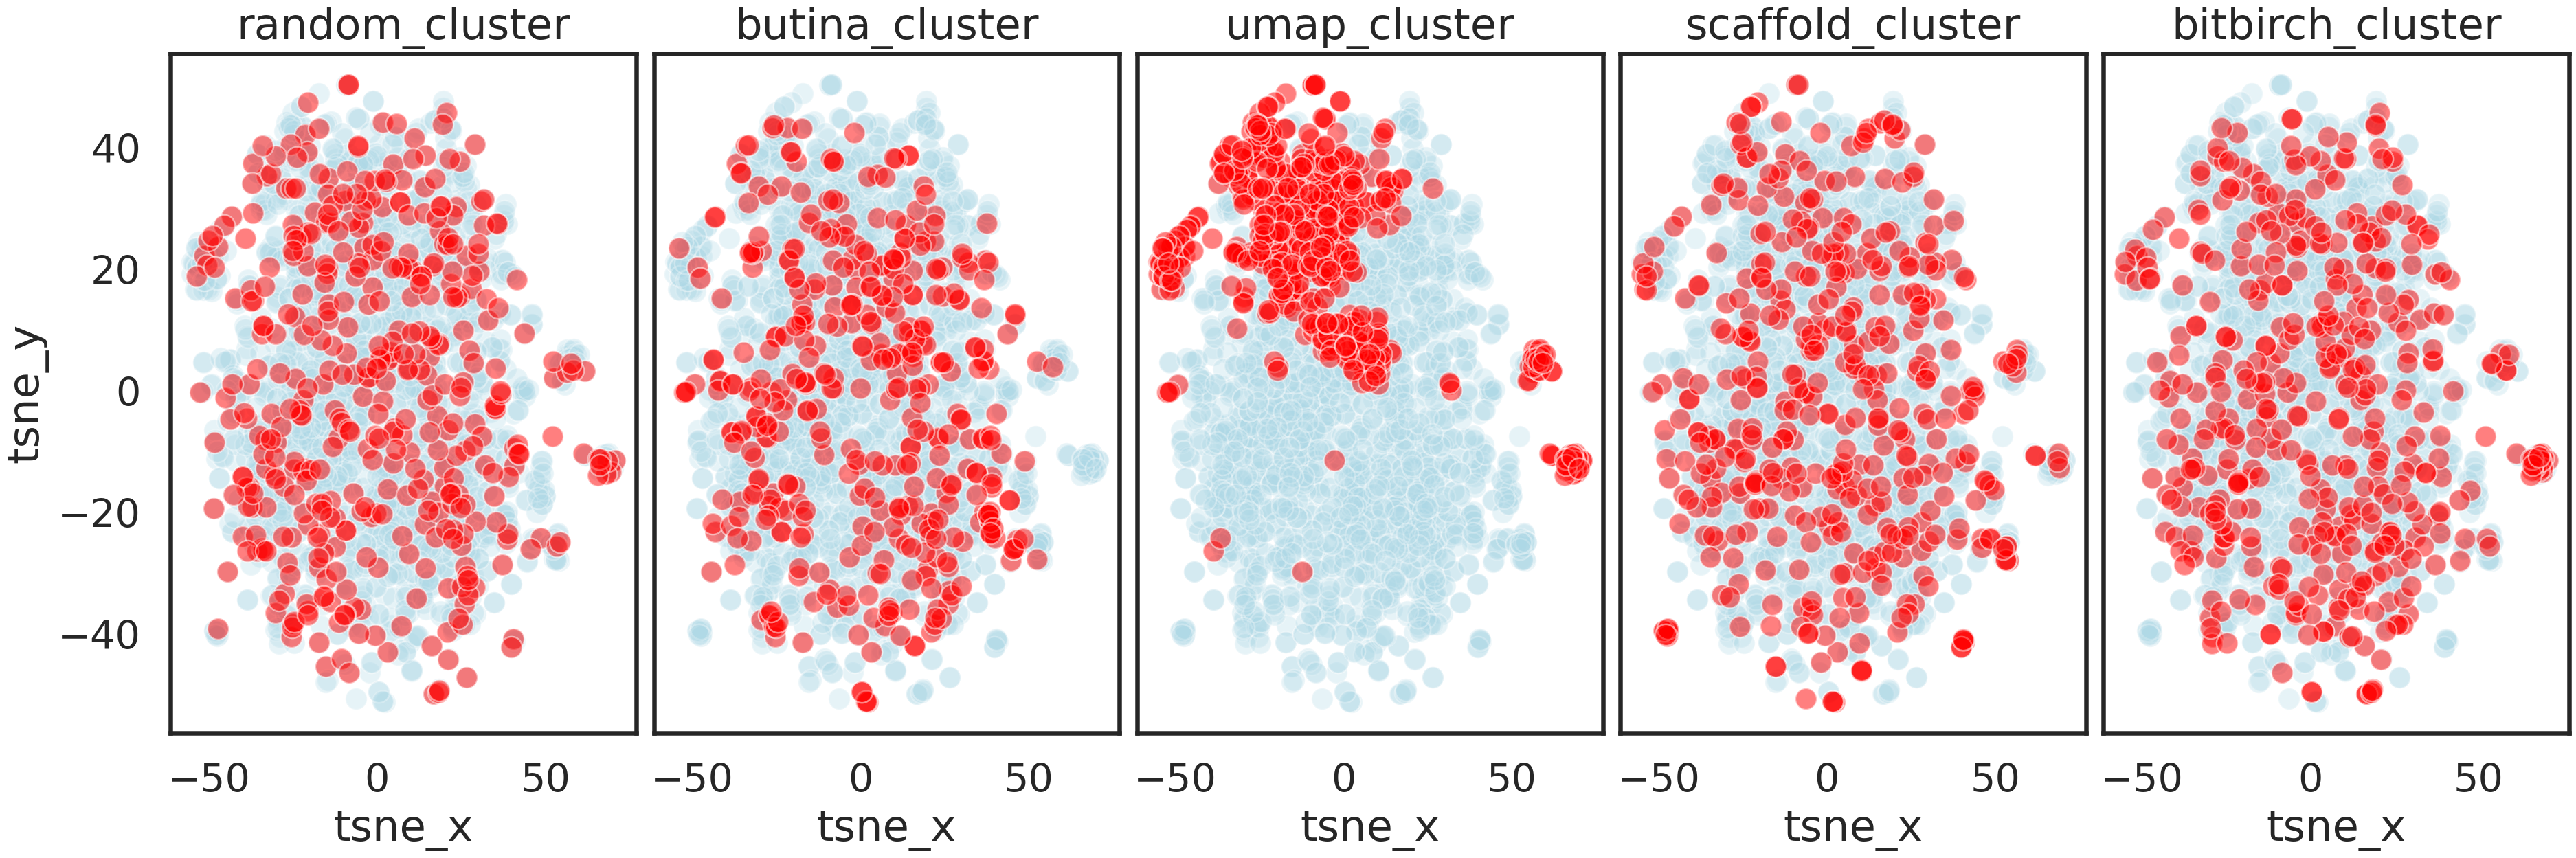

In [28]:
sns.set_style('white')
sns.set_context('talk')
figure, axes = plt.subplots(1,5, figsize=(15,5),sharey=True)
for i,split in enumerate(SPLIT_LIST):
    scatter_ax = sns.scatterplot(x="tsne_x",y="tsne_y",data=tmp_df.query(f"{split} == 'train'"),ax=axes[i],color="lightblue",                            
                                alpha=0.3, legend=False)
    sns.scatterplot(x="tsne_x",y="tsne_y",data=tmp_df.query(f"{split} == 'test'"),ax=axes[i],color="red",                            
                                alpha=0.5, legend=False)
    scatter_ax.set_title(split)

#### Calculate the Tanimoto Similarity Between the Training and Test Sets

The t-SNE plots weren't very satisfying. Instead, let's try another approach.  We will
make box plots comparing the similarity to the 5 nearest training set neighbors for each
test set molecule.  First we'll write a function to do the similarity calculations.

In [29]:
def train_test_tanimoto(train_smiles_list, test_smiles_list, top_n=5):
    fp_gen = rdFingerprintGenerator.GetMorganGenerator()
    train_mol_list = [Chem.MolFromSmiles(x) for x in train_smiles_list]
    # Binary fingerprints
    train_fp_list = [fp_gen.GetFingerprint(x) for x in train_mol_list]
    test_mol_list = [Chem.MolFromSmiles(x) for x in test_smiles_list]
    test_fp_list = [fp_gen.GetFingerprint(x) for x in test_mol_list]
    result_list = []
    for test_fp in test_fp_list:
        sim_list = BulkTanimotoSimilarity(test_fp, train_fp_list)
        sim_array = np.array(sim_list)
        idx = np.argpartition(np.array(sim_array),-top_n)[-top_n:]
        best_n_tanimoto = sim_array[idx]
        result_list.append(best_n_tanimoto)    
    return np.array(result_list).flatten()

Perform 5x5-fold cross validation calculating the Tanimoto similarity between test set
molecules and training set molecules. 

In [30]:
df_list = []
for split in SPLIT_LIST:
    fold = 0
    idx = 0
    for i in tqdm(range(0,5),desc=split):
        kf = uru.GroupKFoldShuffle(n_splits=5, shuffle=True)
        for train_idx, test_idx in kf.split(df,groups=df[split]):
            train = df.iloc[train_idx]
            test = df.iloc[test_idx] 
            sim_vals = train_test_tanimoto(train.SMILES, test.SMILES)
            idx = np.arange(0,len(sim_vals)) + fold*len(sim_vals)
            sim_df = pd.DataFrame({"sim" : sim_vals, "fold" : fold, "split" : split, "idx" : idx })
            fold += 1
            df_list.append(sim_df)

random_cluster:   0%|          | 0/5 [00:00<?, ?it/s]

butina_cluster:   0%|          | 0/5 [00:00<?, ?it/s]

umap_cluster:   0%|          | 0/5 [00:00<?, ?it/s]

scaffold_cluster:   0%|          | 0/5 [00:00<?, ?it/s]

bitbirch_cluster:   0%|          | 0/5 [00:00<?, ?it/s]

Plot distributions of Tamimoto similarity for the 5 nearest neighbors for each test set
molecule.  Only plot the first 10 cross-validation folds so the plot doesn't get overly
crowded. 

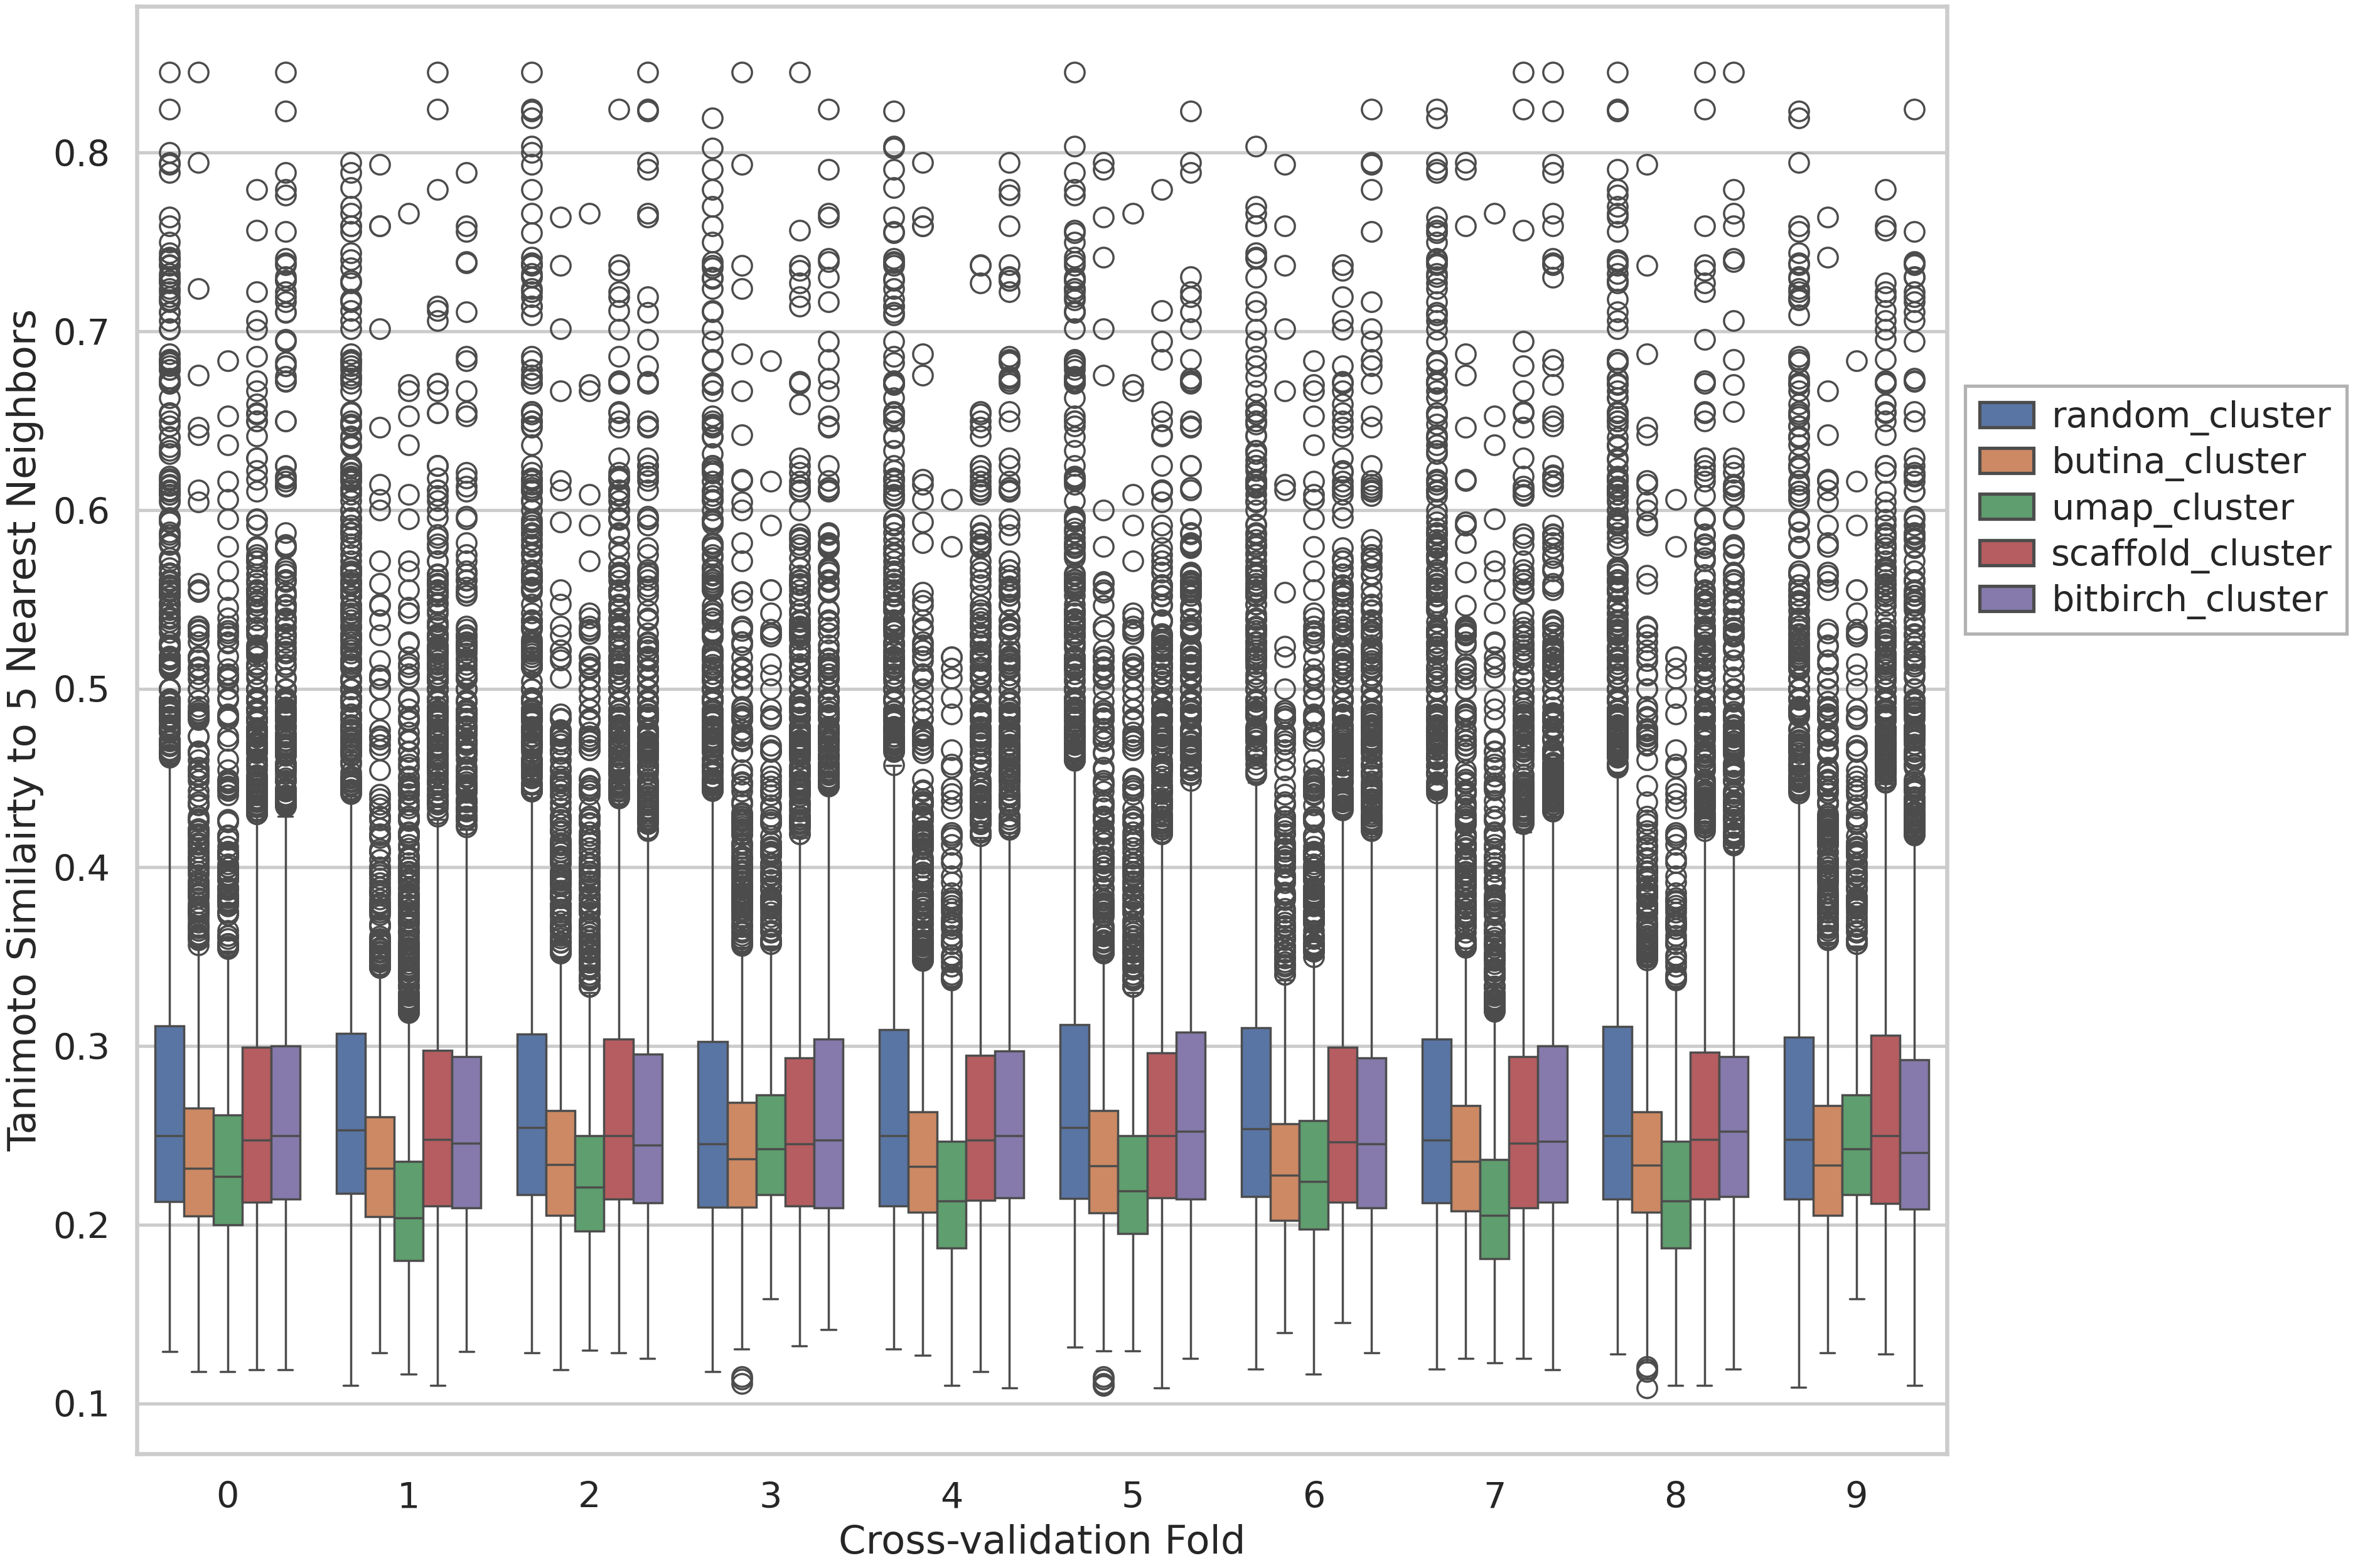

In [31]:
combo_df = pd.concat(df_list)
sns.set(rc={'figure.figsize' : (15,10)})
sns.set_style('whitegrid')
sns.set_context('talk')
ax = sns.boxplot(data=combo_df.query("fold < 10"),x="fold",y="sim",hue="split")
ax.legend(loc='upper left', bbox_to_anchor=(1.00, 0.75), ncol=1)
ax.set_xlabel("Cross-validation Fold")
ax.set_ylabel("Tanimoto Similairty to 5 Nearest Neighbors");

Make boxplots of Tanimoto similarity of each test set molecule to its 5 nearest
neighbors.  This is simply the plot above where all cross-validation fold are pooled. 

<Axes: xlabel='split', ylabel='sim'>

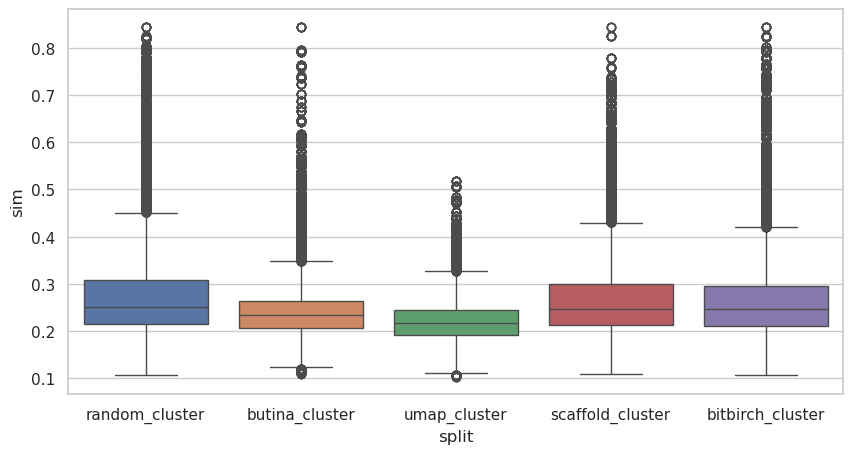

In [25]:
sns.set(rc={'figure.figsize' : (10,5)})
sns.set_style('whitegrid')
sns.boxplot(data=combo_df, x="split", y="sim", hue="split")

As stated by Walters, there is a "a strong correlation between model performance and the
similarity of each test set molecule to its five nearest training set neighbors".
**random_cluster**, **bitbirch_cluster** and **scaffold_cluster** provide more neighbors
compared to the other methods. 

Use the Tukey Honestly Significant Difference (HSD) test to determine whether the
differences between Tanimoto similairty distributions are signficant. 

In [32]:
tukey_res = pairwise_tukeyhsd(combo_df.sim, combo_df.split)

In [33]:
print(tukey_res)

Multiple Comparison of Means - Tukey HSD, FWER=0.05           
========================================================================
     group1           group2      meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------
bitbirch_cluster   butina_cluster  -0.0256    0.0  -0.027 -0.0242   True
bitbirch_cluster   random_cluster   0.0105    0.0  0.0091  0.0119   True
bitbirch_cluster scaffold_cluster   0.0007 0.6131 -0.0007  0.0021  False
bitbirch_cluster     umap_cluster  -0.0391    0.0 -0.0405 -0.0377   True
  butina_cluster   random_cluster   0.0361    0.0  0.0347  0.0375   True
  butina_cluster scaffold_cluster   0.0263    0.0  0.0249  0.0277   True
  butina_cluster     umap_cluster  -0.0135    0.0 -0.0149 -0.0121   True
  random_cluster scaffold_cluster  -0.0097    0.0 -0.0111 -0.0083   True
  random_cluster     umap_cluster  -0.0496    0.0  -0.051 -0.0482   True
scaffold_cluster     umap_cluster  -0.0399    0.0 -0.0413 -0.0385   True
------------------------------------------------------------------------

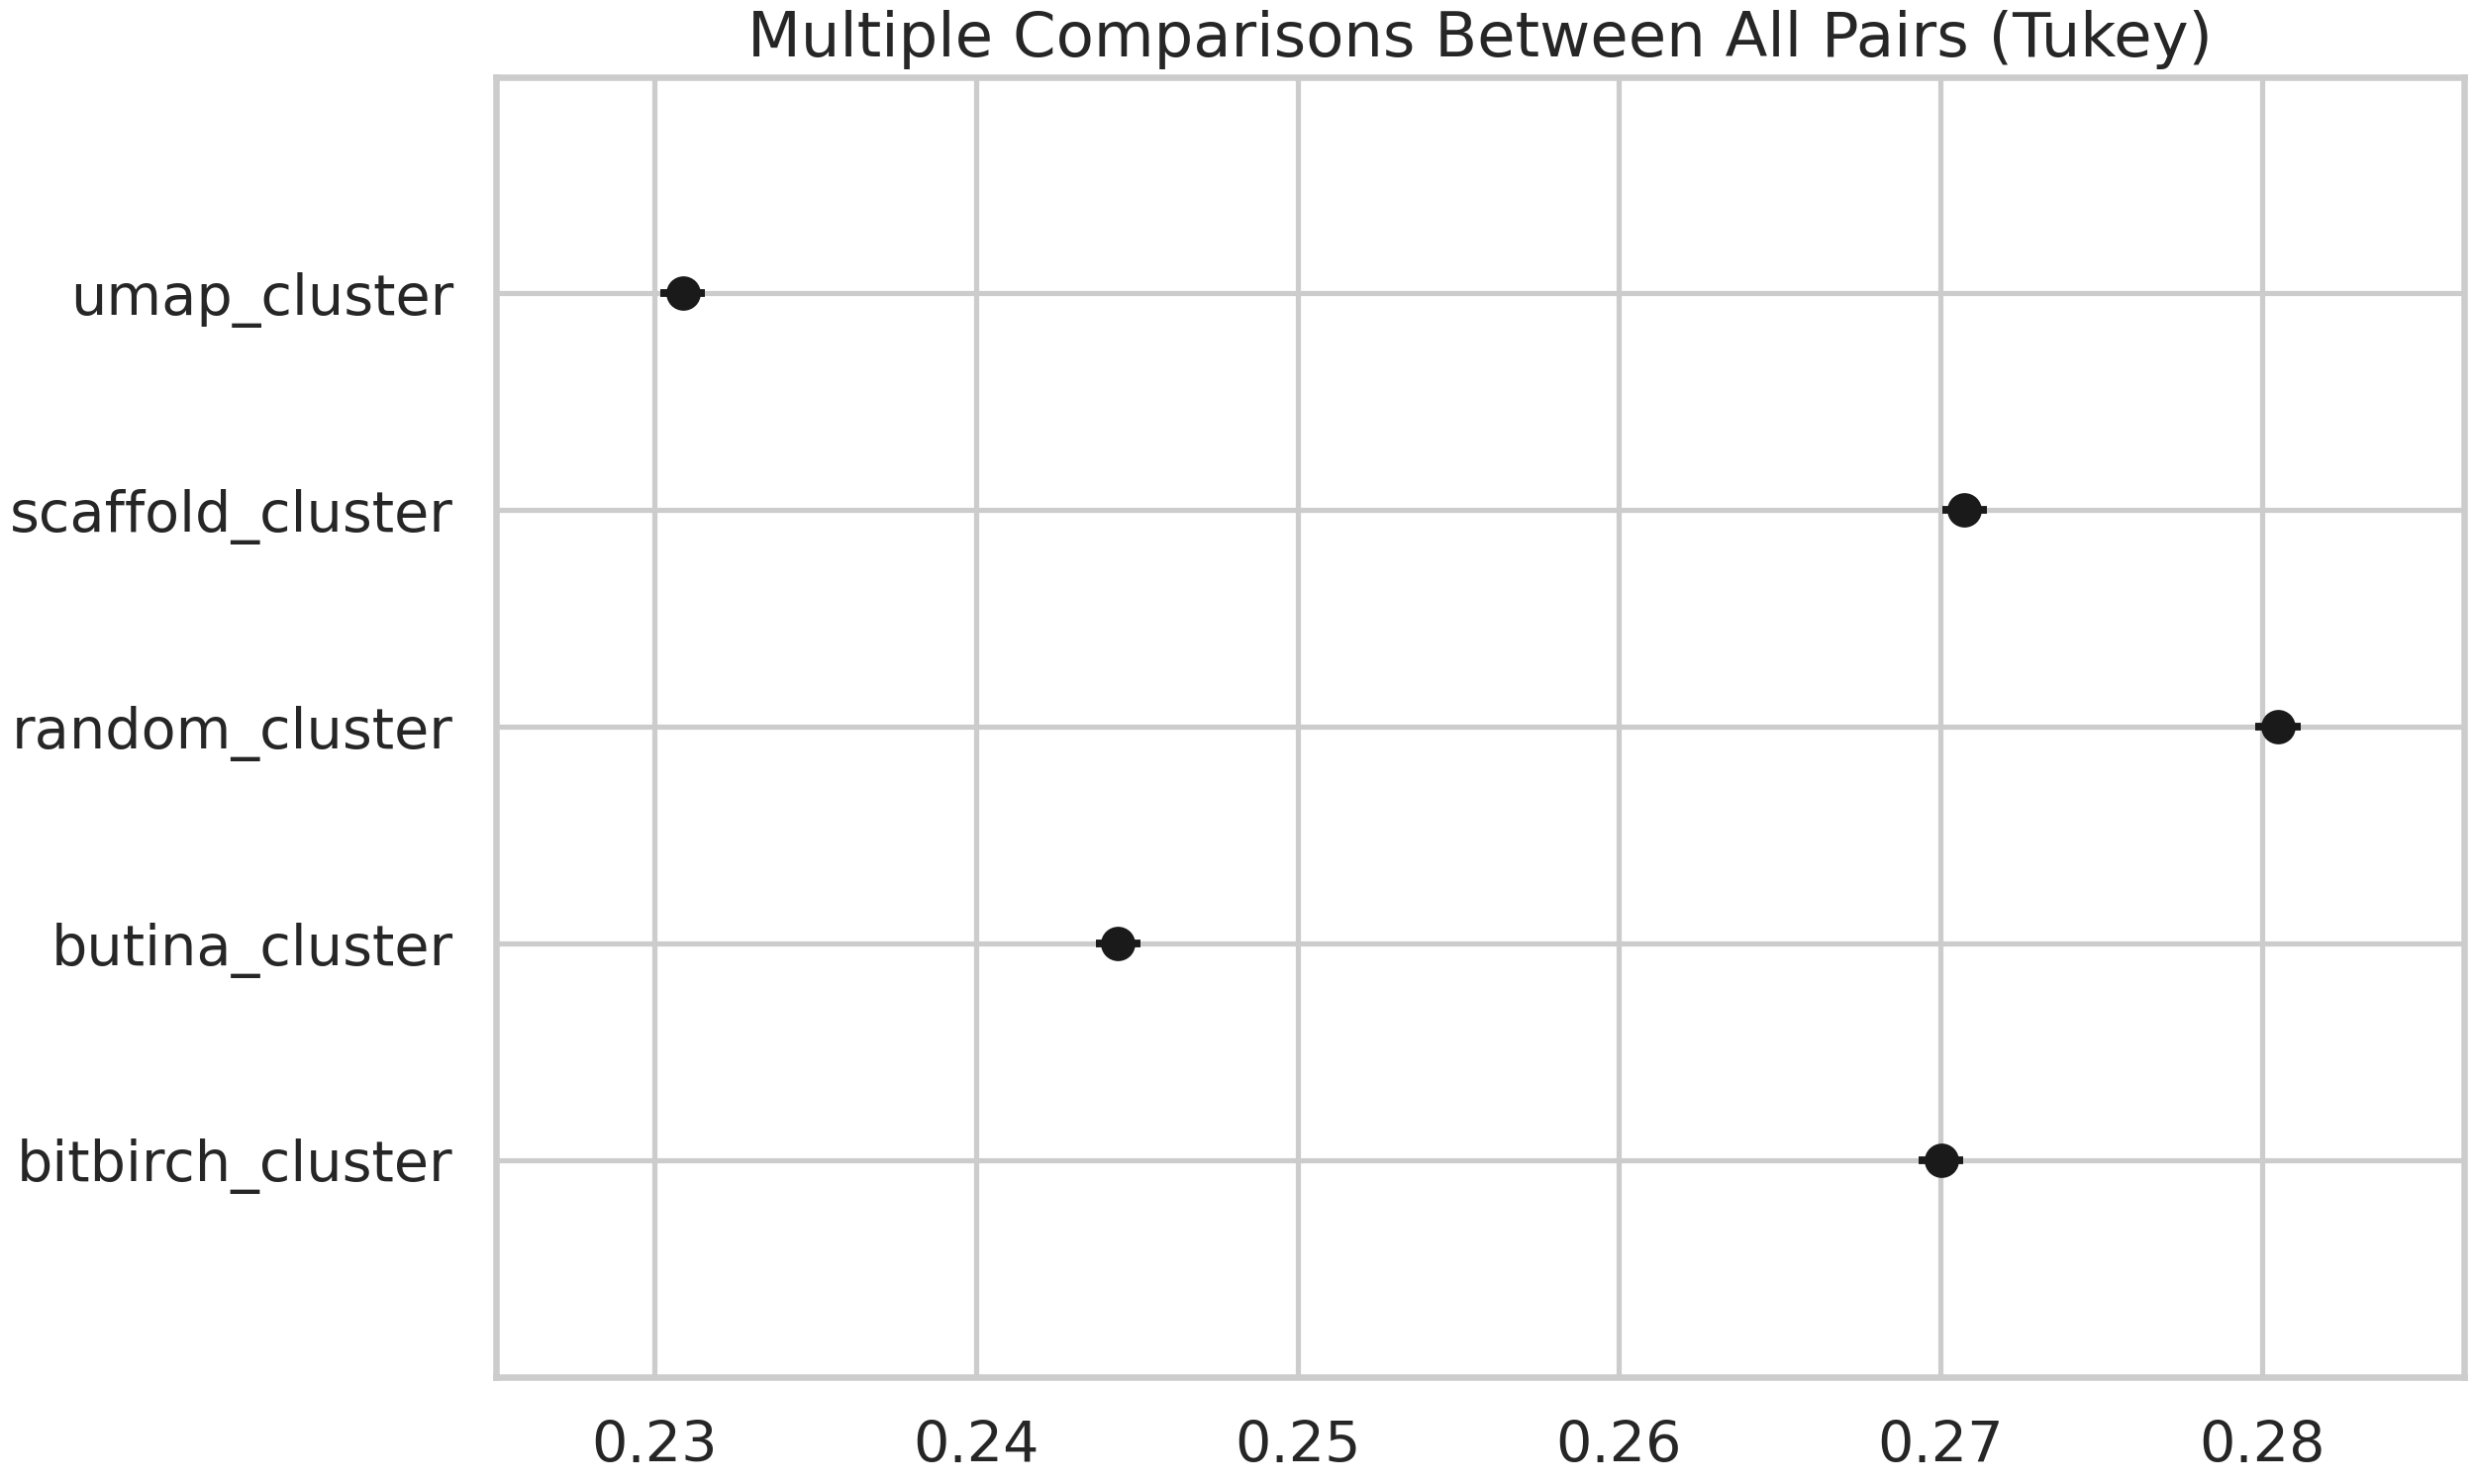

In [35]:
sns.set_style('whitegrid')
sns.set_context('talk')
_ = tukey_res.plot_simultaneous()

#### Examine the Impact of Dataset Splitting on ML Model Performance 

We've seen how the different splitting methods affect the similairty between the
training and test sets.  Now let's see how the same splits impact model performance.  To
do this, we will use the **cross_validate** function in useful_rdkit_utils.  To use the
function we pass the following arguments. 

* An input dataframe, which must contain a SMILES column
* A list of tuples containing a model name and and instance of a wrapper class that runs
  a model. The wrapper class must support an **evaluate** function which takes
  dataframes containing training and test sets as input and returns a list of
  predictions for the test set.
* The name of the **y** variable in the dataframe
* A list of tuples containing a name and a function to group the data.  These groups
  will be passed to an instance of **GroupKFoldShuffle**
* The number of outer cross-validation folds
* The number of inner cross-validation folds

While this may sound complicated, it's actually simple.  The code block below defines
the model list, the group list, and the y column. We are comparing 

* one model - LightGBM
* five splitting methods - butina, random, scaffold, bitbirch, and umap
  
The **y** column in the dataset is **logS**.  That's it. 

In [36]:
model_list = [("lgbm_morgan", LGBMMorganCountWrapper)]
group_list = [("butina", uru.get_butina_clusters), ("random", uru.get_random_clusters),
              ("scaffold", uru.get_bemis_murcko_clusters), ("umap", uru.get_umap_clusters),
              ("bitbirch", get_bitbirch_clusters)]
y = "logS"

With the definitions above, call **cross_validate**, which returns a dataframe with the
training and test sets for each fold, as well as the predicted values. 

In [37]:
result_df = uru.cross_validate(df, model_list, y, group_list, 5, 5)
outfile_name = "biogen_logS_results.csv"
result_df.to_csv(outfile_name, index=False)

  0%|          | 0/5 [00:00<?, ?it/s]

butina:   0%|          | 0/5 [00:00<?, ?it/s]

/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, 

random:   0%|          | 0/5 [00:00<?, ?it/s]

/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, 

scaffold:   0%|          | 0/5 [00:00<?, ?it/s]

/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, 

umap:   0%|          | 0/5 [00:00<?, ?it/s]

/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, 

bitbirch:   0%|          | 0/5 [00:00<?, ?it/s]

/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, 

butina:   0%|          | 0/5 [00:00<?, ?it/s]

/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, 

random:   0%|          | 0/5 [00:00<?, ?it/s]

/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, 

scaffold:   0%|          | 0/5 [00:00<?, ?it/s]

/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, 

umap:   0%|          | 0/5 [00:00<?, ?it/s]

/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, 

bitbirch:   0%|          | 0/5 [00:00<?, ?it/s]

/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, 

butina:   0%|          | 0/5 [00:00<?, ?it/s]

/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, 

random:   0%|          | 0/5 [00:00<?, ?it/s]

/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, 

scaffold:   0%|          | 0/5 [00:00<?, ?it/s]

/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, 

umap:   0%|          | 0/5 [00:00<?, ?it/s]

/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, 

bitbirch:   0%|          | 0/5 [00:00<?, ?it/s]

/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, 

butina:   0%|          | 0/5 [00:00<?, ?it/s]

/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, 

random:   0%|          | 0/5 [00:00<?, ?it/s]

/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, 

scaffold:   0%|          | 0/5 [00:00<?, ?it/s]

/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, 

umap:   0%|          | 0/5 [00:00<?, ?it/s]

/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, 

bitbirch:   0%|          | 0/5 [00:00<?, ?it/s]

/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, 

butina:   0%|          | 0/5 [00:00<?, ?it/s]

/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, 

random:   0%|          | 0/5 [00:00<?, ?it/s]

/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, 

scaffold:   0%|          | 0/5 [00:00<?, ?it/s]

/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, 

umap:   0%|          | 0/5 [00:00<?, ?it/s]

/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, 

bitbirch:   0%|          | 0/5 [00:00<?, ?it/s]

/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/ipickering/Conda/envs/bblean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, 

Now, we'll calculate some statistics on the dataset.  To do this, we only need the data
from the test set. 

In [38]:
test_df = result_df.query("dset == 'test'")

Collect the data from the cross-validation folds and calculate $R^2$ for each fold.
This will give us a distribution of $R^2$ values for each splitting method. 

In [39]:
out_list = []
for k,v in test_df.groupby(["group","fold"]):
    group, fold = k
    r2 = r2_score(v.logS,v.lgbm_morgan)
    out_list.append([group, fold, r2])
out_df = pd.DataFrame(out_list,columns=["split","fold","r2"])

In [40]:
out_df

split  fold        r2
0    bitbirch     0  0.312611
1    bitbirch     1  0.431988
2    bitbirch     2  0.344050
3    bitbirch     3  0.331048
4    bitbirch     4  0.268541
..        ...   ...       ...
120      umap    20  0.319851
121      umap    21  0.225263
122      umap    22  0.443892
123      umap    23  0.302504
124      umap    24  0.121679

[125 rows x 3 columns]

Plot a boxplot showing the $R^2$ distributions for each splitting method. 

Text(0.5, 0, 'Split')

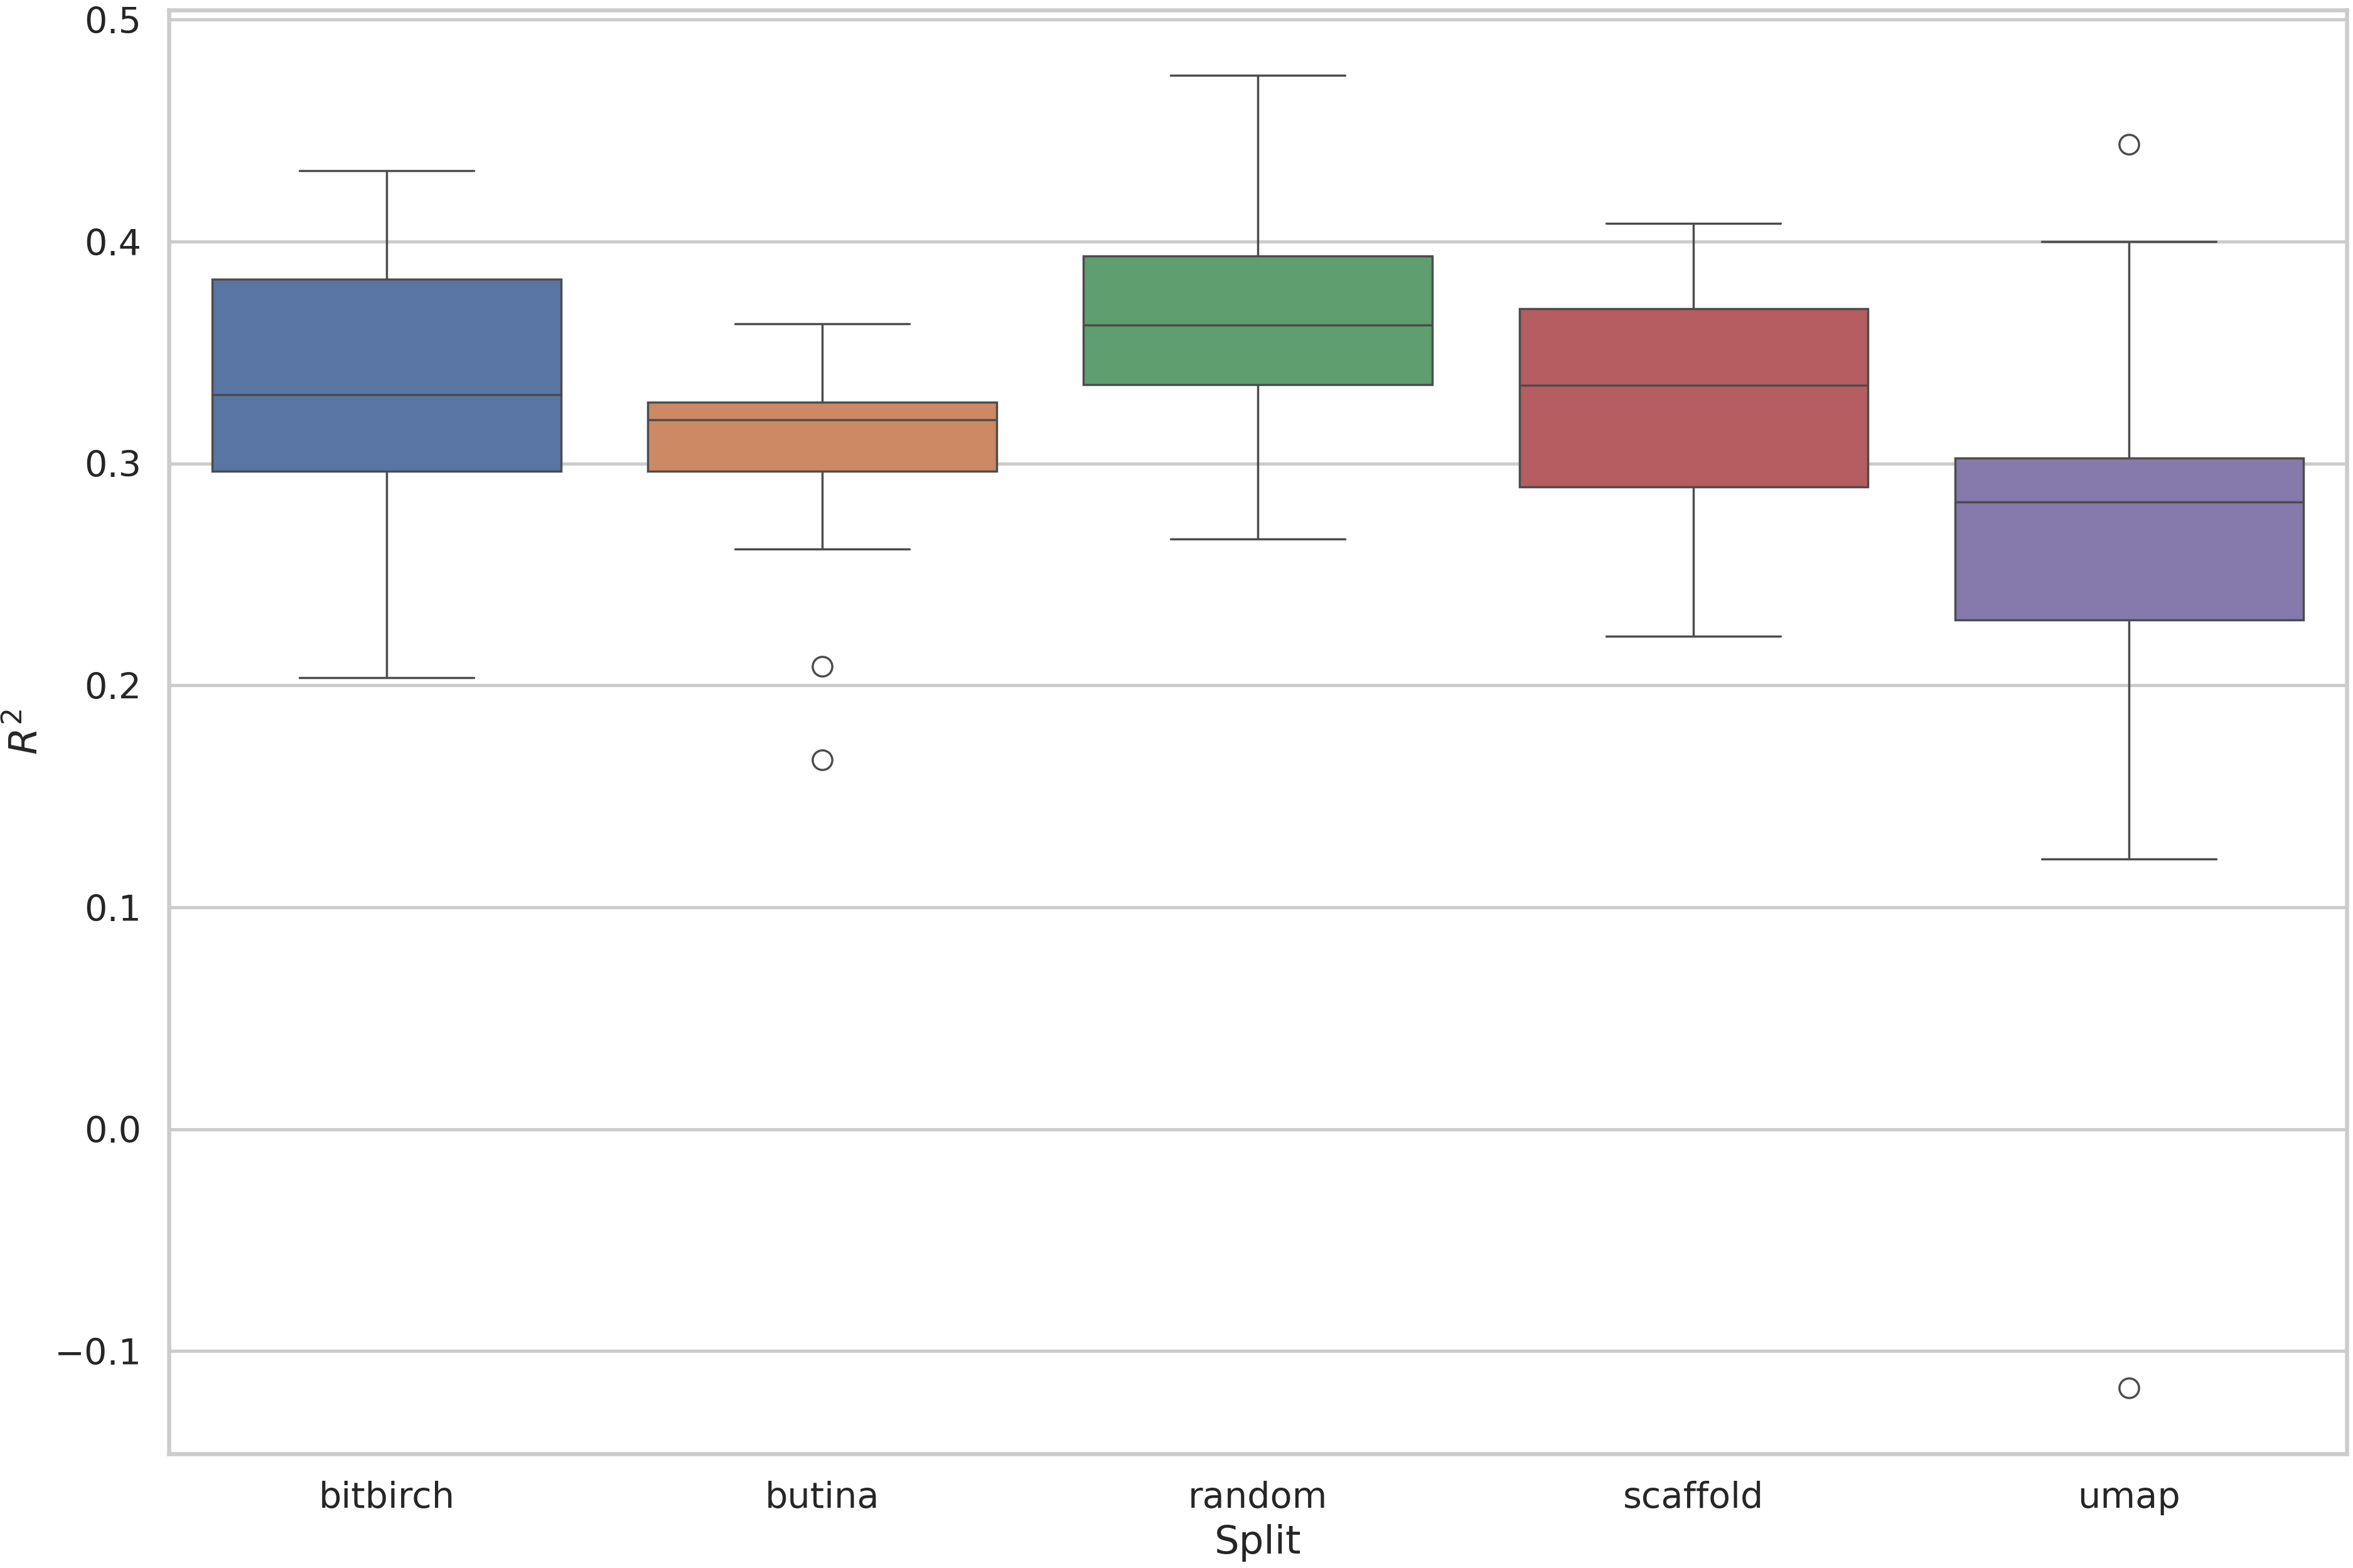

In [41]:
sns.set_style('whitegrid')
ax = sns.boxplot(x="split",y="r2",hue="split",data=out_df)
ax.set_ylabel("$R^2$")
ax.set_xlabel("Split")

From the plot above, it's clear that the **umap** splits are the most challenging for
the model.  The $R^2$ distributions for the **bitbirch** split and the **random** split
appear similar, generating models with higher $R^2$ values. We can use the Tukey HSD
test to determine whether statistically significant differences exist between the
splitting methods.  The table **tukey_res** table below shows the following. 

* **group1** - the first split being compared
* **group2** - the second split being compared
* **meandiff** - the mean difference between the two splitting methods
* **p-adj** - the p-value for the difference between distributions, corrected for multiple comparisons
* **lower** - the lower bound of the confidence interval
* **upper** - the upper bound of thhe confidence interval
* **reject** - can we reject the null hypothesis that the means of the distributions are the same

In [42]:
tukey_res = pairwise_tukeyhsd(out_df.r2, out_df.split)

In [43]:
print(tukey_res)

Multiple Comparison of Means - Tukey HSD, FWER=0.05   
========================================================
 group1   group2  meandiff p-adj   lower   upper  reject
--------------------------------------------------------
bitbirch   butina  -0.0229 0.7427 -0.0751  0.0293  False
bitbirch   random   0.0361 0.3146 -0.0161  0.0883  False
bitbirch scaffold   -0.002    1.0 -0.0542  0.0502  False
bitbirch     umap  -0.0709 0.0024 -0.1232 -0.0187   True
  butina   random    0.059 0.0183  0.0068  0.1113   True
  butina scaffold   0.0209 0.8011 -0.0313  0.0731  False
  butina     umap   -0.048 0.0871 -0.1003  0.0042  False
  random scaffold  -0.0381 0.2624 -0.0903  0.0141  False
  random     umap  -0.1071    0.0 -0.1593 -0.0548   True
scaffold     umap   -0.069 0.0034 -0.1212 -0.0167   True
--------------------------------------------------------

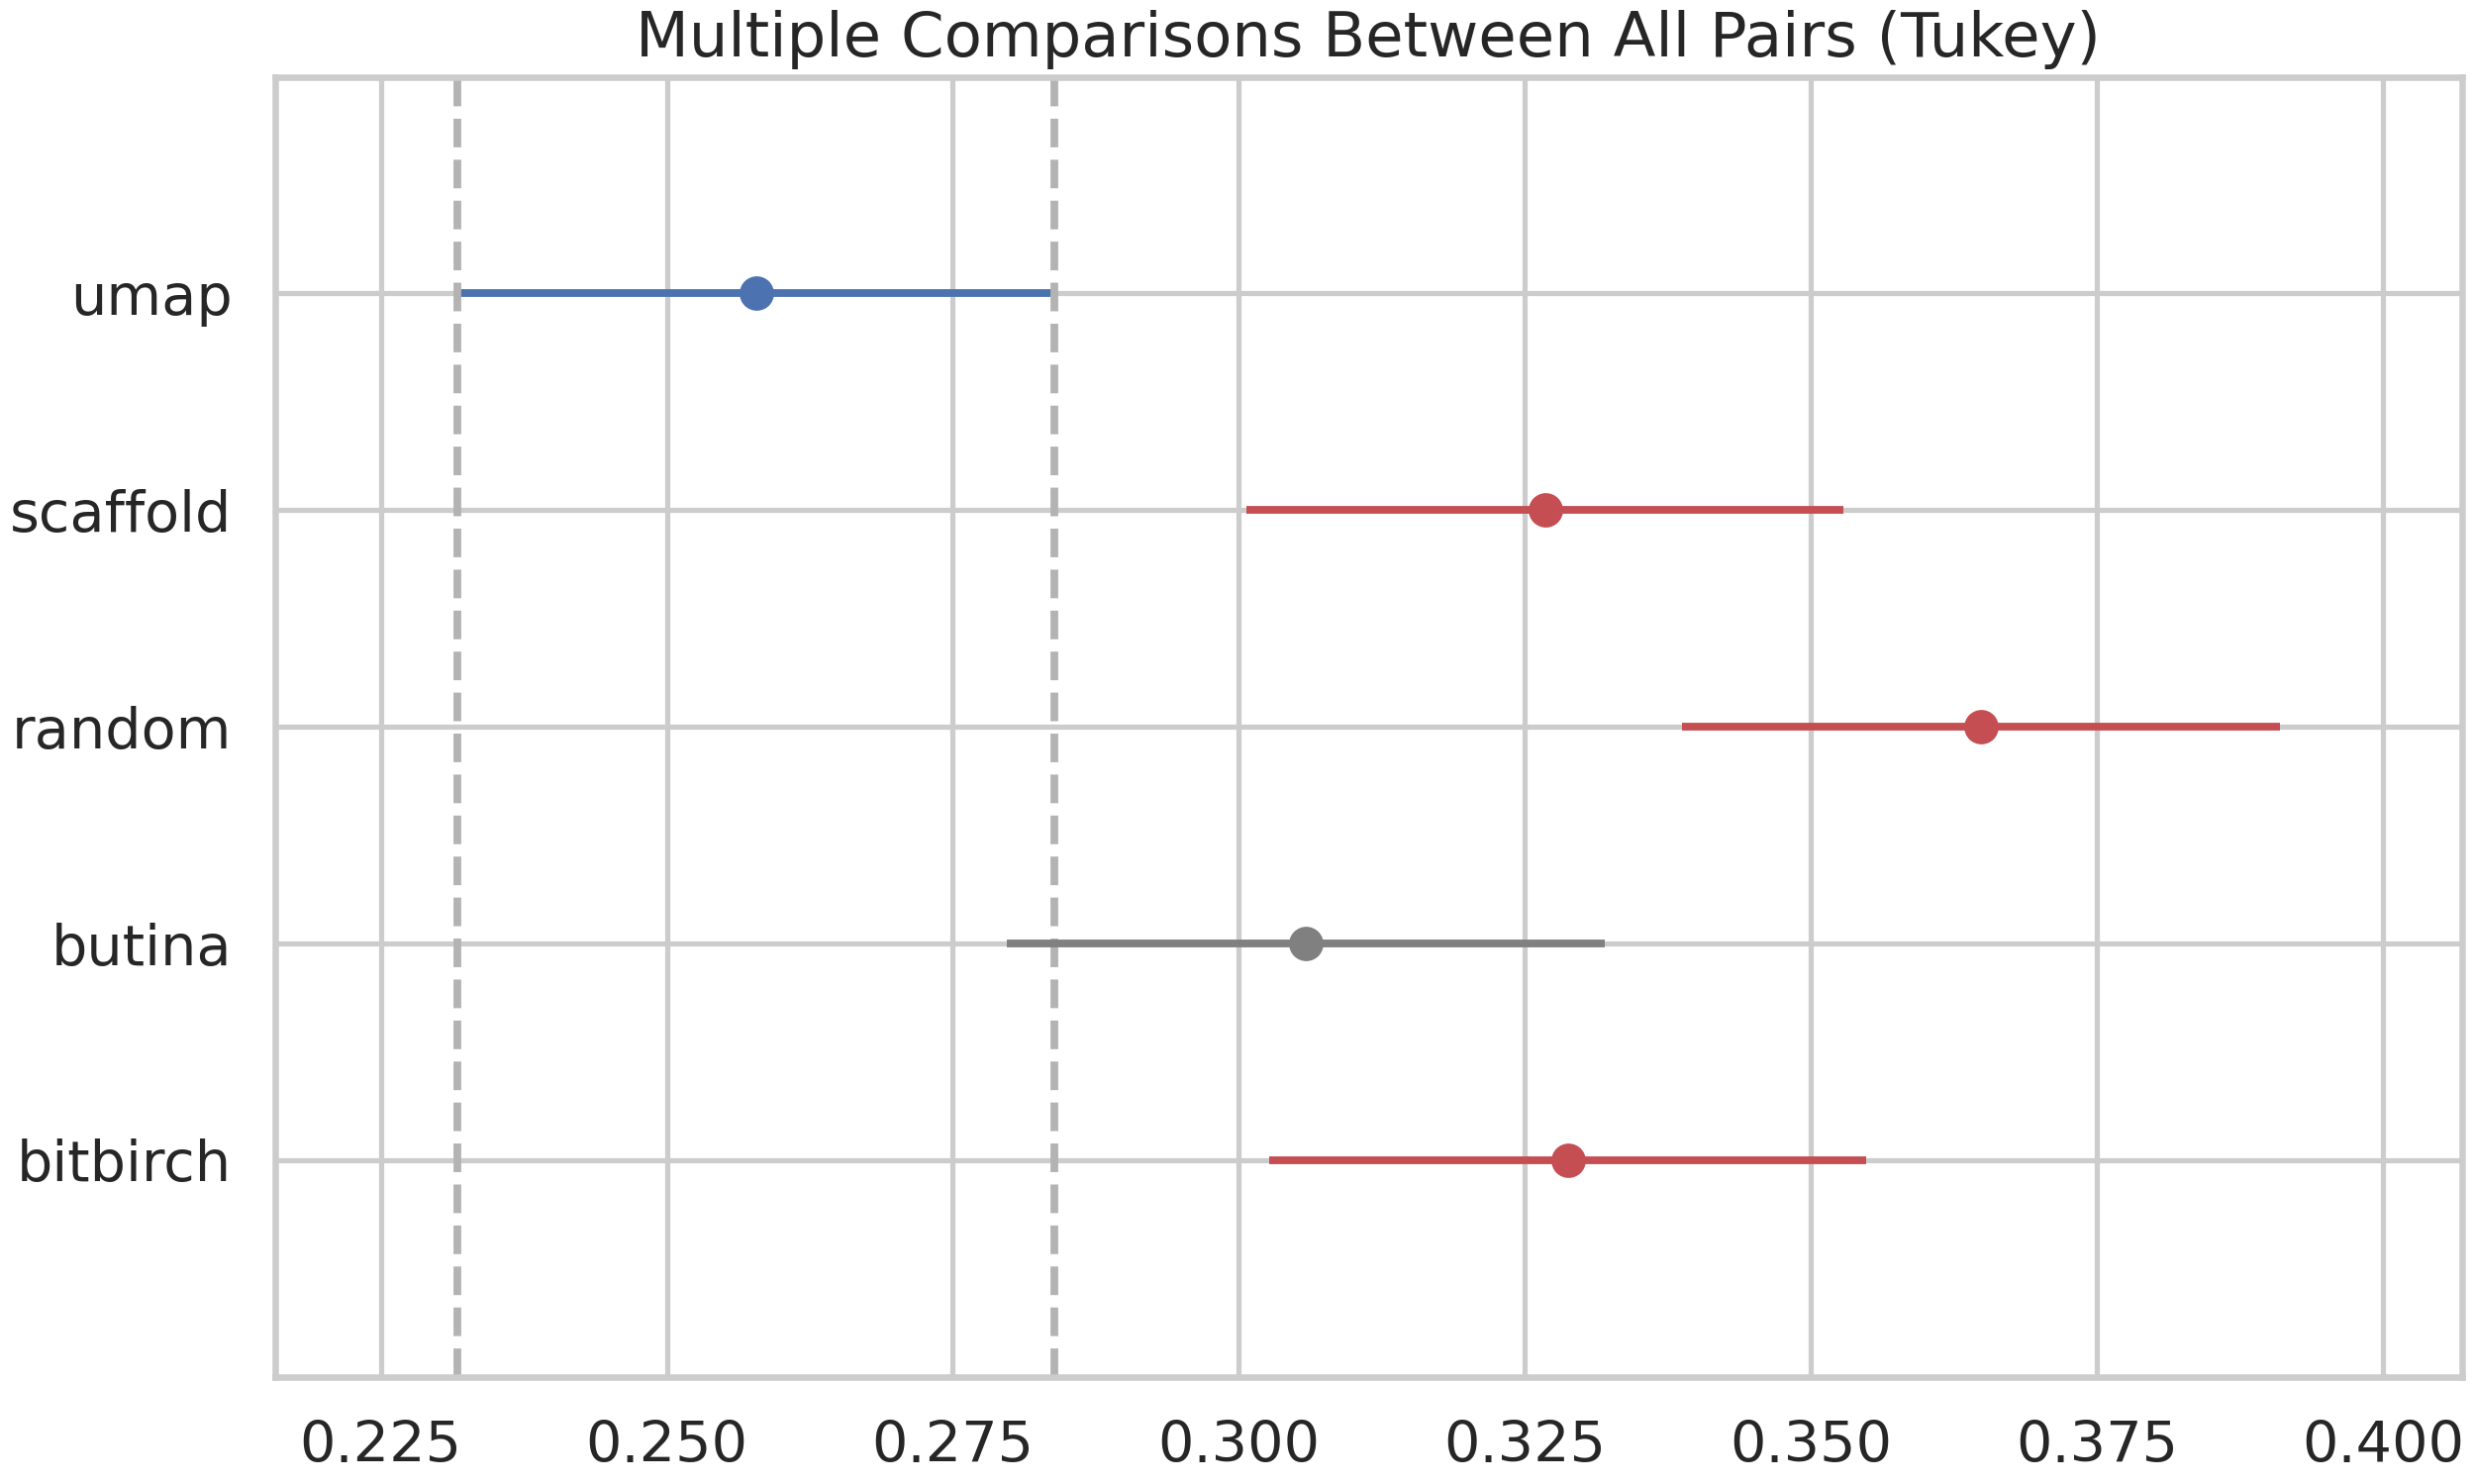

In [44]:
sns.set_style('whitegrid')
sns.set_context('talk')
_ = tukey_res.plot_simultaneous(comparison_name="umap")

## Compare BitBIRCH and Butina Timing

We would like to see how the speed of **BitBIRCH** compares to that of **Butina**. We
want to only compare the clustering method itself, without having to account for the
fingerprint computation. Now that we have stored fingerprints in size_df, we will do a
quick comparison of the two methods. 

In [45]:
def numpy_to_explicit_bitvect(fp):
    bitvect = ExplicitBitVect(len(fp))  
    for idx, val in enumerate(fp):
        if val:  
            bitvect.SetBit(idx)
    return bitvect

#### Comparison with biogen data (2173 total molecules)

In [46]:
data = np.array(size_df.binary_fps.values.tolist())
rdkit_fp_list = [numpy_to_explicit_bitvect(fp) for fp in data]

In [48]:
s_time = time.time()
bitbirch = bblean.BitBirch(branching_factor=50, threshold=0.65)  
bitbirch.fit(data)
bitbirch_time = time.time() - s_time
print('Time for BitBIRCH Clustering (s):', bitbirch_time)

dists = []
nfps = len(rdkit_fp_list)
s_time = time.time()
for i in range(1, nfps):
    sims = BulkTanimotoSimilarity(rdkit_fp_list[i], rdkit_fp_list[:i])
    dists.extend([1 - x for x in sims])
cluster_res = Butina.ClusterData(dists, nfps, 0.65, isDistData=True)
butina_time = time.time() - s_time
print('Time for Butina Clustering (s):', butina_time)


Time for BitBIRCH Clustering (s): 0.3302001953125

Time for Butina Clustering (s): 0.6039228439331055

We see on the biogen dataset, of 2173 structures, **BitBIRCH** performs significantly faster
than **Butina** (around 2x). Let's see how the two methods compare
on a larger dataset. 

#### Comparison with sample of the Chembl library (20,000 total molecules)

In [49]:
chembl_smis = bblean.load_smiles("./chembl-33-natural-products-subset.smi")[:20_000]
fps = bblean.fingerprints

chembl_rdkit_fp_list = [numpy_to_explicit_bitvect(fp) for fp in chembl_fps]

FileNotFoundError: [Errno 2] No such file or directory: 'chembl_20Ksample_fps.npy'

In [42]:
s_time = time.time()
bitbirch = bblean.BitBirch(branching_factor=50, threshold=0.65)  
bitbirch.fit(chembl_fps, input_is_packed=False)
bitbirch_time = time.time() - s_time
print('Time for BitBIRCH Clustering (s):', bitbirch_time)


dists = []
nfps = len(chembl_rdkit_fp_list)
s_time = time.time()
for i in range(1, nfps):
    sims = BulkTanimotoSimilarity(chembl_rdkit_fp_list[i], chembl_rdkit_fp_list[:i])
    dists.extend([1 - x for x in sims])
cluster_res = Butina.ClusterData(dists, nfps, 0.65, isDistData=True)
butina_time = time.time() - s_time
print('Time for Butina Clustering (s):', butina_time)

/home/kdavis2/notebook_workflow/splitting_personal/bitbirch.py:279: RuntimeWarning: invalid value encountered in divide
  sim_matrix = a / (np.sum(self.centroids_, axis = 1) + set_bits - a)
/home/kdavis2/notebook_workflow/splitting_personal/bitbirch.py:51: RuntimeWarning: invalid value encountered in scalar divide
  return a/(a + n_objects * sum_kq - sum_kqsq)


Time for BitBIRCH Clustering (s): 3.7092125415802
Time for Butina Clustering (s): 37.512155294418335


We see BitBIRCH vastly outperforms Butina in regards to speed on a dataset of 20k
structures. 